In [3]:
from utils import *

In [ ]:
### Old simulation that sim graph and then points
def generateSimdata(loss=10, rand=2, noise=0, n_samples=100,x_1d=100):
    columns = [      "n_vx",
                    "#connects",
                    "std of lengths",
                    "mean std of lengths",
                    "percentage of area",
                    "elastic_energy",
                    "dev_60",
                    "dev_30",
                    "std of all angles",
                    "mean std of angles",
                    "n_peak",
                    "main_angle",
                    "highest_peak", 
                    "largest_angle", 
                    "std of three main angles",
                    "mean length",
                    "mean angle",
                    "mean sm angle",
                    "#triangles",
                    ]
    t_r=0.15
    p_size=16
    thre=[50,280]
    stats_1d = []
    stats_2d = []
    stats_rand = []
    stats_rand2 = []
    raw_data = []
    for i in range(n_samples):
        vxs_1D = sim1D(size=int(2*64*16/p_size), spacex=int(x_1d/p_size), spacey=int(187/p_size))
        vxs_1D = jitter(vxs_1D,loss=np.random.randint(loss),noise=noise)
        sim_1D = genPic(np.zeros([128,128]), vxs_1D, 5, theta=np.random.rand()*180, rand=rand, randz=3)
        mat = sim_1D[32:32+64,32:32+64]
        vxs = readVXSfromMat(mat, min_sigma=0.5,max_sigma=1,num_sigma=20, threshold_rel=t_r,plot=0)[0]
        raw_data.append(vxs)     
        stats_1d.append(statsForVXS(vxs*p_size, thre=thre))

    for i in range(n_samples):
        vxs_2D = sim2D(size=int(2*64*16/p_size), space=int(187/p_size/2))
        vxs_2D = jitter(vxs_2D,loss=np.random.randint(loss),noise=noise)
        sim_2D = genPic(np.zeros([128,128]), vxs_2D, 5, theta=np.random.rand()*180, rand=rand, randz=3)
        mat = sim_2D[32:32+64,32:32+64]
        vxs = readVXSfromMat(sim_2D[32:32+64,32:32+64], min_sigma=0.5,max_sigma=1,num_sigma=20, threshold_rel=t_r,plot=0)[0]
        raw_data.append(vxs)
        stats_2d.append(statsForVXS(vxs*p_size, thre=thre))

    for i in range(n_samples):
        x=0
        while x < 3:
            x = int(np.random.normal(48.8,15.6))
        vxs_rand = simRand(size=int(2*64*16/p_size),n=4*x)
        sim_rand = genPic(np.zeros([128,128]), vxs_rand, 5, theta=np.random.rand()*180, rand=rand, randz=3)
        mat = sim_rand[32:32+64,32:32+64]
        # raw_data.append(mat)
        vxs = readVXSfromMat(sim_rand[32:32+64,32:32+64], min_sigma=0.5,max_sigma=1,num_sigma=20, threshold_rel=t_r,plot=0)[0]
        if len(vxs)>20:
            stats_rand.append(statsForVXS(vxs*p_size, thre=thre))
            raw_data.append(vxs)

    for i in range(n_samples):
        x=0
        while x < 3:
            x = int(np.random.normal(48.8,15.6))
        vxs_randD = simRandD(size=64*16, d=65, n=x)
        if len(vxs_randD) > 10:
            vxs = jitter(vxs_randD, rand=rand*16, loss=np.min([len(vxs_randD)-2,np.random.randint(loss)]), noise=np.random.randint(10))
            if len(vxs) > 20:
                raw_data.append(vxs)
                stats_rand2.append(statsForVXS(vxs, thre=thre))
        
    tmp = []
    for i, (stat, category) in enumerate(zip([stats_1d,stats_2d, stats_rand, stats_rand2],[1,2,0,3])):
        df = pd.DataFrame(
                np.array(stat),
                    columns=columns)
        df["conds"]=category
        tmp.append(df)
    train_df = pd.concat(tmp)
    train_np = train_df.to_numpy()
    X_data = train_np[:,:-1]
    y_data = train_np[:,-1]
    return X_data,y_data, raw_data, train_df

In [133]:
def jitter(vxs, rand=0, loss=0, noise=0):
    def jitter_theta(vx, rand, theta):
        return [
            vx[0] + rand * np.cos(theta),
            vx[1] + rand * np.sin(theta),
        ]

    if rand:

        vxs = np.array(
            [jitter_theta(x,np.sqrt(np.random.rand())*rand, np.random.rand() * 2 * np.pi) for x in vxs]
        )
    if loss:
        n_vx = len(vxs)
        idx = np.random.choice(n_vx, n_vx - loss, replace=False)
        vxs = vxs[idx]
    if noise:
        n_vx = len(vxs)
        xmax, ymax = np.max(vxs, axis=0)
        vxs = np.concatenate(
            (
                vxs,
                [
                    [xmax * np.random.rand(), ymax * np.random.rand()]
                    for x in range(noise)
                ],
            ),
            axis=0,
        )
    return vxs

In [55]:
def statsForVXS(vxs, thre=[150, 220], mode=1, std=187, relaxed_length=100, bandwidth=12, plot=0):
    # use density and connectivity as rules for simulating data
    # connectivity
    # uniformity: distance to the mean length
    # sparsity: percentage of area / Nextra
    # energy: 1/2*k*deltax^2
    n_vx = len(vxs)
    links = generateLinks(vxs, thre=thre, plot=plot)
    connects = np.mean(np.sum(links, 0))
    angles = getAngle(vxs, links)

    if mode == 0:
        return [n_vx, connects]

    tri_list = getTrianglesFromList(convertMatrix2List(links))
    # t_vxs = getTrianglesCentroid(tri_list, vxs)
    n_tris = len(tri_list)
    dist = distance_matrix(vxs, vxs)
    linked_dist = links * dist
    lengths = [[x for x in y if x != 0] for y in linked_dist]
    mean_length_std = np.mean([np.std(x) for x in lengths if len(x) > 1])
    lengths = [x for x in linked_dist.flatten() if x != 0]
    length_std = np.std(lengths)
    mean_length = np.mean(lengths)
    x0, y0 = np.min(vxs, 0)
    x1, y1 = np.max(vxs, 0)
    p_area = AreaCoveredByTriangles(tri_list, vxs) / (y1 - y0) / (x1 - x0)
    elastic_energy = np.sum([1 / 2 * (x - relaxed_length) ** 2 for x in lengths])
    dev_60 = calAngleDev(angles, 60)
    dev_30 = calAngleDev(angles, 30)
    mean_angle_std = np.mean([np.std(x) for x in angles if len(x) > 1])
    all_angles = []
    for x in angles:
        all_angles.extend(x)
    angle_std = np.std(all_angles)
    mean_angle = np.mean(all_angles)
    mean_sm_angle = np.mean([ x for x in all_angles if x<90])
    # v_c = Voronoi_cv(vxs)
    # v_e = Voronoi_edges(vxs)
    # tris = len(t_vxs)

    angles = getTop3Angle(vxs, links)
    angles = np.array(angles).reshape(-1, 1)
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(angles)
    s = np.linspace(-180, 180, 361)
    probs = kde.score_samples(s.reshape(-1, 1))

    l_min, l_max = argrelextrema(probs, np.less)[0], argrelextrema(probs, np.greater)[0]
    # print(l_max)
    peaks_idx = [x for x in l_max if x < l_max[1] + 180][1:]
    # print(peaks_idx)
    n_peak = len(peaks_idx)
    peaks_prob = [probs[x] for x in peaks_idx]
    highest_peak = max(peaks_prob)
    peaks_angle = [peaks_idx[x] for x in np.argsort(peaks_prob)[-3:][::-1]]
    if n_peak == 1:
        main_angle = 180
        largest_angle = 180
        std_angles = 0
    else:
        main_angle = (
            np.abs(peaks_angle[1] - peaks_angle[0])
            if np.abs(peaks_angle[1] - peaks_angle[0]) <= 90
            else 180 - np.abs(peaks_angle[1] - peaks_angle[0])
        )
        angles = np.sort(peaks_angle)
        angles = np.concatenate(
            (angles[1:] - angles[:-1], [180 - np.sum(angles[1:] - angles[:-1])])
        )
        largest_angle = np.max(angles)
        std_angles = np.std(angles)
    return [
        n_vx,
        connects,
        length_std,
        mean_length_std,
        p_area,
        elastic_energy,
        dev_60,
        dev_30,
        angle_std,
        mean_angle_std,
        n_peak,
        main_angle,
        highest_peak,
        largest_angle,
        std_angles,
        mean_length,
        mean_angle,
        mean_sm_angle,
        n_tris
    ]

In [152]:
def rand_rdc(vxs, theta, center=(0, 0), size=64):
    """Rotate a point around a given point.
    
    I call this the "high performance" version since we're caching some
    values that are needed >1 time. It's less readable than the previous
    function but it's faster.
    """

    n_vxs = np.array(vxs) - center
    cos_rad = np.cos(theta)
    sin_rad = np.sin(theta)
    vxs = [[size/2 + cos_rad * vx[0] + sin_rad * vx[1],
    size/2 + -sin_rad * vx[0] + cos_rad * vx[1]] for vx in n_vxs ] 
    vxs = [ vx for vx in vxs if 0<vx[0]<size and 0<vx[1]<size]

    return np.array(vxs)

In [ ]:
def sim1Df(size, spacex=100, spacey=187, shift=0):
    for py in range(1, size, spacey):
        for px in range(1 + py // int(spacey) * shift, size, spacex):
            points.append([px, py])
    return np.array(points)

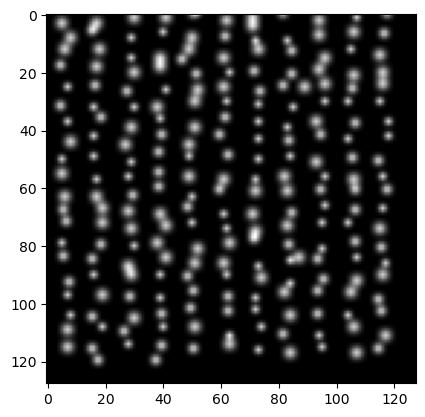

In [150]:
p_size=16
x_1d=100
loss=1
noise=5
rand=2
vxs_1D = sim1D(size=int(2*64*16/p_size), spacex=int(x_1d/p_size), spacey=int(187/p_size))
vxs_1D = jitter(vxs_1D,loss=np.random.randint(loss),noise=noise)
sim_1D = genPic(np.zeros([128,128]), vxs_1D, 5, theta=0, rand=rand, randz=3)
plt.imshow(sim_1D)

In [170]:
def generateSimdata(loss=10, rand=2, noise=0, n_samples=100,x_1d=100):
    columns = [      "n_vx",
                    "#connects",
                    "std of lengths",
                    "mean std of lengths",
                    "percentage of area",
                    "elastic_energy",
                    "dev_60",
                    "dev_30",
                    "std of all angles",
                    "mean std of angles",
                    "n_peak",
                    "main_angle",
                    "highest_peak", 
                    "largest_angle", 
                    "std of three main angles",
                    "mean length",
                    "mean angle",
                    "mean sm angle",
                    "#triangles",
                    ]
    p_size=16
    thre=[50,280]
    stats_1d = []
    stats_2d = []
    stats_rand = []
    stats_rand2 = []
    raw_data = []
    for i in range(n_samples):
        vxs_1D = sim1D(size=64*16*2, spacex=x_1d, spacey=187)
        vxs_1D = jitter(vxs_1D,loss=np.random.randint(loss),noise=noise)
        vxs = rand_rdc(vxs_1D,theta=np.random.rand()*np.pi,center=[64*16,64*16],size=64*16)
        raw_data.append(vxs)     
        stats_1d.append(statsForVXS(vxs, thre=thre))

    for i in range(n_samples):
        vxs_2D = sim2Df(size=2*64*16, space=187/2)
        vxs_2D = jitter(vxs_2D,loss=np.random.randint(loss),noise=noise)
        vxs = rand_rdc(vxs_2D, theta=np.random.rand()*np.pi,center=[64*16,64*16],size=64*16)
        raw_data.append(vxs)
        stats_2d.append(statsForVXS(vxs, thre=thre))

    for i in range(n_samples):
        x=0
        while x < 3:
            x = int(np.random.normal(48.8,15.6))
        vxs_rand = simRand(size=2*64*16,n=4*x)
        vxs = rand_rdc(vxs_rand, theta=np.random.rand()*np.pi,center=[64*16,64*16],size=64*16)
        if len(vxs)>20:
            stats_rand.append(statsForVXS(vxs, thre=thre))
            raw_data.append(vxs)

    for i in range(n_samples):
        x=0
        while x < 3:
            x = int(np.random.normal(48.8,15.6))
        vxs_randD = simRandD(size=64*16, d=65, n=x)
        if len(vxs_randD) > 10:
            vxs = jitter(vxs_randD, rand=rand*16, loss=np.min([len(vxs_randD)-2,np.random.randint(loss)]), noise=np.random.randint(10))
            if len(vxs) > 20:
                raw_data.append(vxs)
                stats_rand2.append(statsForVXS(vxs, thre=thre))
        
    tmp = []
    for i, (stat, category) in enumerate(zip([stats_1d,stats_2d, stats_rand, stats_rand2],[1,2,0,3])):
        df = pd.DataFrame(
                np.array(stat),
                    columns=columns)
        df["conds"]=category
        tmp.append(df)
    train_df = pd.concat(tmp)
    train_np = train_df.to_numpy()
    X_data = train_np[:,:-1]
    y_data = train_np[:,-1]
    return X_data,y_data, raw_data, train_df

### 0,1,2 train

In [171]:
acc=[]
scs=[]
X, y, vxss, train_df = generateSimdata(loss=20, noise=10, rand=2, n_samples=200)
idx=[ x for x in range(len(y)) if y[x]!=3]

ffs = [[x] for x in range(19)]
for features in ffs:
    t_score, accuracy, lbls = testAllClass(X[:,features][idx],y[idx], vxss=vxss,debug=0, methods=[6])
    acc.append(accuracy)
    scs.append(t_score)

In [58]:
    columns = [      "n_vx",
                    "#connects",
                    "std of lengths",
                    "mean std of lengths",
                    "percentage of area",
                    "elastic_energy",
                    "dev_60",
                    "dev_30",
                    "std of all angles",
                    "mean std of angles",
                    "n_peak",
                    "main_angle",
                    "highest_peak", 
                    "largest_angle", 
                    "std of three main angles",
                    "mean length",
                    "mean angle",
                    "mean sm angle",
                    "#triangles"
                    ]

([<matplotlib.axis.XTick at 0x1ba3d0ea720>,
 [Text(0, 0, 'Random'), Text(1, 0, '1D'), Text(2, 0, '2D')])

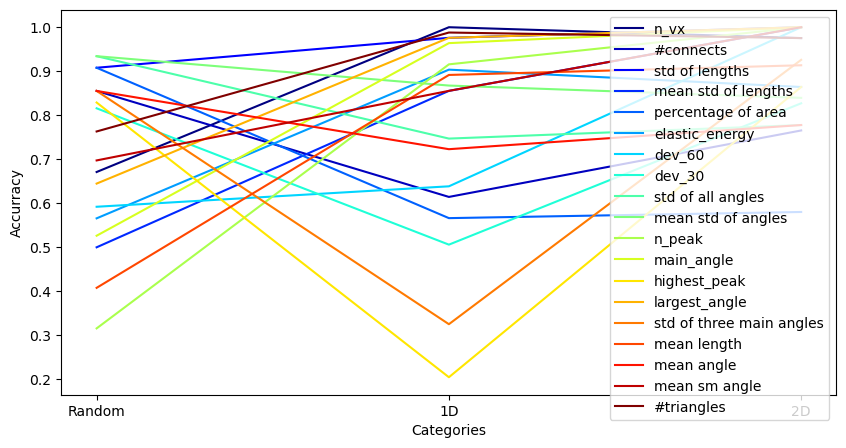

In [66]:
plt.figure(figsize=[10,5])
n = 19
colors = plt.cm.jet(np.linspace(0,1,n))
for i in range(n):
    plt.plot(np.array(acc)[i,0,:].T, color=colors[i])
plt.legend(columns)
plt.xlabel("Categories")
plt.ylabel("Accurracy")
plt.xticks(ticks=[0,1,2],labels=["Random","1D","2D"])

In [46]:
X[0][-1] / (360/X[0][1])

0.9833333333333332

Text(0, 0.5, 'Scores')

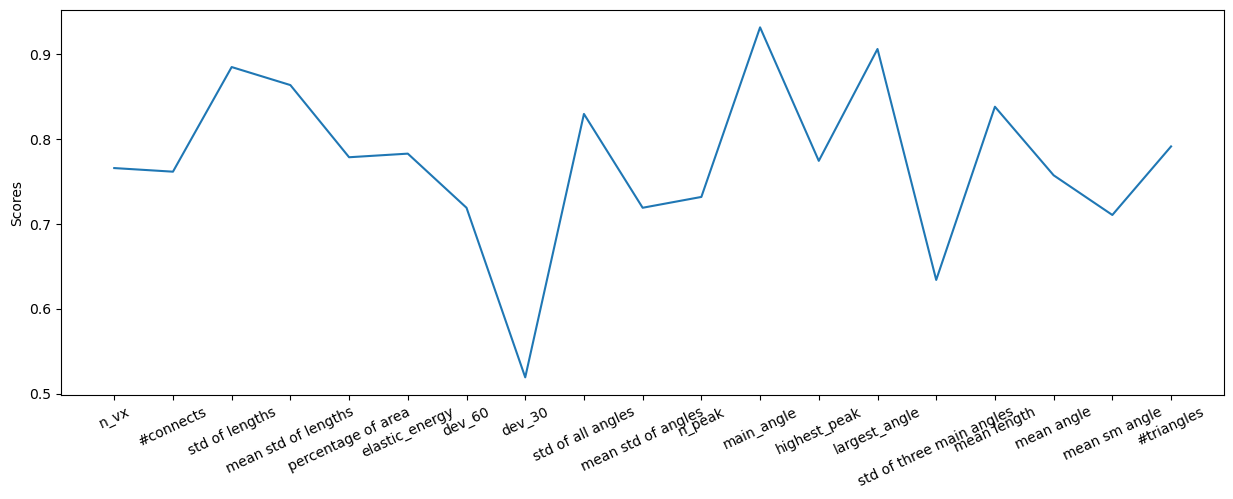

In [173]:
plt.figure(figsize=[15,5])
plt.plot(scs)
plt.xticks([x for x in range(19)],columns,rotation=25)
plt.ylabel("Scores")
# plt.plot(np.mean(np.array(acc)[:,0,:],1))
# plt.legend(["Scores","Average Accuracy"])

In [72]:
def testAllClass(X, y, vxss=None, thre=[50,280], methods=[6,9], debug=0, n_debug=10):
    names = [
        "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
        "Gaussian Process",
        "Decision Tree",
        "Random Forest",
        "Neural Net",
        "AdaBoost",
        "Naive Bayes",
        "QDA",
    ]

    classifiers = [
        KNeighborsClassifier(5),
        SVC(kernel="linear", C=0.025, random_state=42),
        SVC(gamma=2, C=1, random_state=42),
        GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
        DecisionTreeClassifier(max_depth=5, random_state=42),
        RandomForestClassifier(
            max_depth=5, n_estimators=10, max_features=7, random_state=42
        ),
        MLPClassifier(alpha=1, max_iter=1000, random_state=42),
        AdaBoostClassifier(algorithm="SAMME", random_state=42),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
    ]

    # X = X_data
    # y = y_data
    X_train, X_test, y_train, y_test , idx_train, idx_test= train_test_split(
            np.nan_to_num(X), y, np.arange(len(y)), test_size=0.4, random_state=42
    )

    scores = np.zeros(len(methods))
    seperate_accuracy = np.zeros([len(methods),len(np.unique(y)),len(np.unique(y))])
    for i, (name, clf) in enumerate(zip([names[x] for x in methods], [classifiers[x] for x in methods])):
        # ax = plt.subplot(1, len(classifiers) + 1, i)
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        scores[i]=clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        lbl = np.unique(y)
        for j, y_k in enumerate(y_test):
            seperate_accuracy[i, np.where(lbl == y_k), np.where(lbl==y_pred[j])] +=1

        for j in range(len(lbl)):
            seperate_accuracy[i,j,:]/=np.sum(seperate_accuracy[i,j,:])
        if debug == 1:
            incorrect = [ k for k in range(len(y_test)) if y_test[k]!=y_pred[k] ]
            #plt.subplots(round(n_debug/5),5)
            n_y = round(n_debug/5)
            plt.figure(figsize = (10, 2*n_y))
            for ki, k in enumerate(np.random.choice(incorrect,min(len(incorrect),n_debug),False)):
                plt.subplot(n_y, 5, ki+1)
                vxs = vxss[idx_test[k]]
                links = generateLinks(vxs*16, thre=thre, plot=0)
                visualize(vxs,links,thre=thre,p_size=16)
                plt.xticks([], [])
                plt.yticks([], [])
                plt.title(str(int(y_test[k]))+" mis as "+str(int(y_pred[k])))
            plt.suptitle(name+" Error Examples:")
    return scores, seperate_accuracy, lbl

In [73]:
t_score, accuracy, lbls = testAllClass(X[:,features][idx],y[idx], vxss=vxss,debug=0, methods=[6])

Text(0.5, 1.0, 'Density Probability Distribution in Simulated Data')

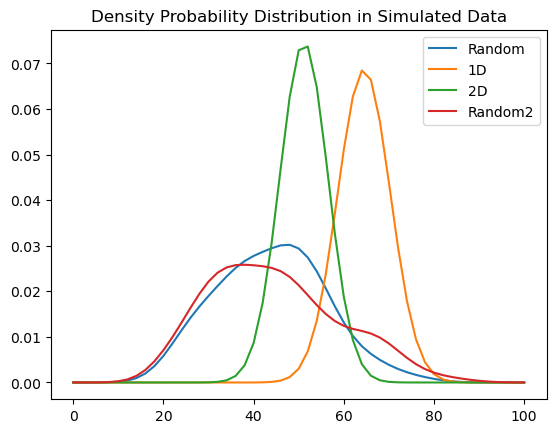

In [98]:
for i in range(4):
    idx = [ x for x in range(len(y)) if y[x]==i]
    a = X[idx,0].reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(a)
    s = np.linspace(0,100,51)
    e = kde.score_samples(s.reshape(-1,1))
    #ax[1, 0].fill(X_plot[:, 0], np.exp(e), fc="#AAAAFF")
    plt.plot(s, np.exp(e))
    l_max = argrelextrema(e, np.greater)[0]
plt.legend(["Random","1D","2D","Random2"])
plt.title("Density Probability Distribution in Simulated Data")



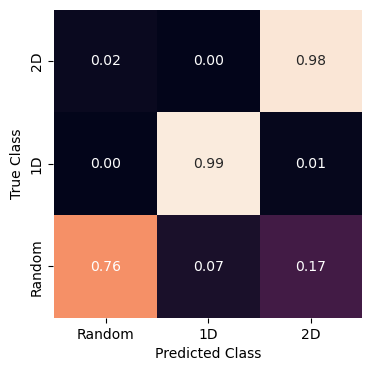

In [94]:
plt.figure(figsize=[4,4])
sns.heatmap(np.array(accuracy[0,:,:]),annot=True, fmt=".2f", cbar=False)
labels = [["Random","1D","2D"][int(x)] for x in lbls]
plt.xticks([x+0.5 for x in [0,1,2]],labels)
plt.yticks([x+0.5 for x in [0,1,2]],labels)
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal", adjustable="datalim")

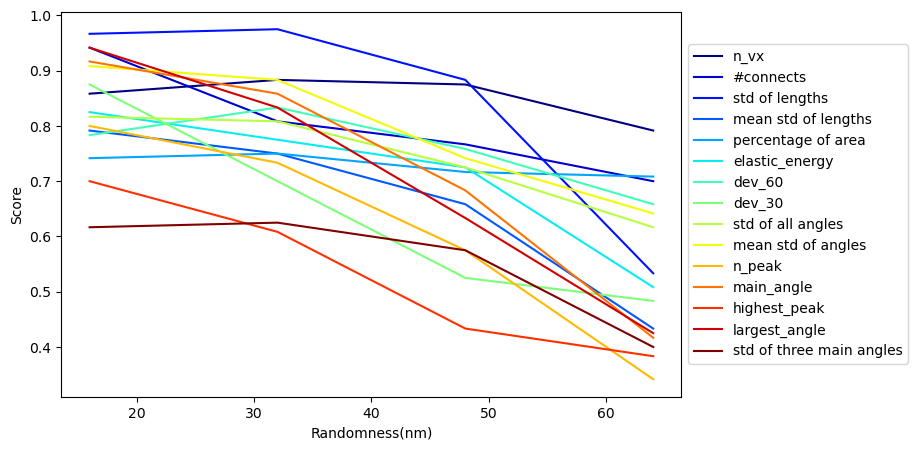

In [11]:
acc=[]
scs=[]
for rand in range(1,5):
    X, y, vxss, train_df = generateSimdata(loss=20, noise=10, rand=rand, n_samples=100)
    idx=[ x for x in range(len(y)) if y[x]!=3]
    for features in [[x] for x in range(len(X[0]))]:
        t_score, accuracy, lbls = testAllClass(X[:,features][idx],y[idx], vxss=vxss,debug=0, methods=[6])
        acc.append(accuracy)
        scs.append(t_score)

scs=np.array(scs)
sscs = np.reshape(scs,[4,15])
fig = plt.figure(figsize=[10,5])
ax = plt.subplot(111)


for i, f in enumerate(columns):
    plt.plot([x*16 for x in range(1,5)],sscs[:,i], color=colors[i])
plt.xlabel("Randomness(nm)")
plt.ylabel("Score")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(columns, loc='center left', bbox_to_anchor=(1, 0.5))

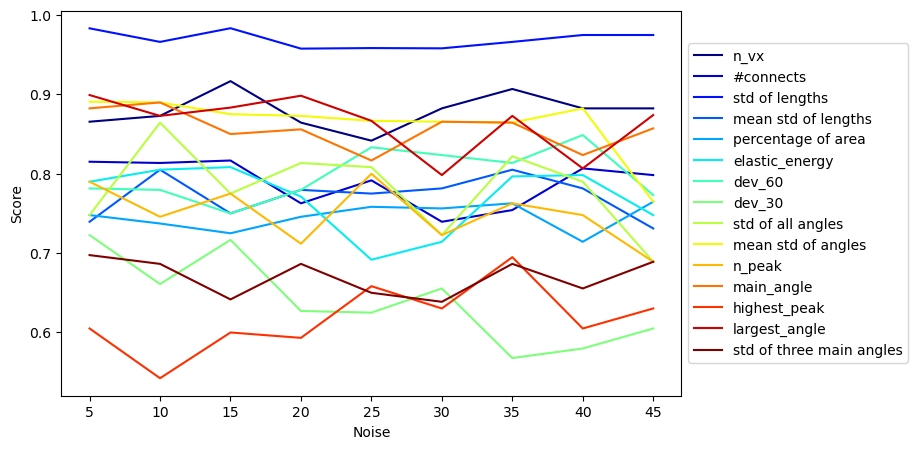

In [14]:
acc=[]
scs=[]
for noise in range(1,10):
    X, y, vxss, train_df = generateSimdata(loss=20, noise=noise*5, rand=2, n_samples=100)
    idx=[ x for x in range(len(y)) if y[x]!=3]
    for features in [[x] for x in range(len(X[0]))]:
        t_score, accuracy, lbls = testAllClass(X[:,features][idx],y[idx], vxss=vxss,debug=0, methods=[6])
        acc.append(accuracy)
        scs.append(t_score)

scs=np.array(scs)
sscs = np.reshape(scs,[9,15])
fig = plt.figure(figsize=[10,5])
ax = plt.subplot(111)


for i, f in enumerate(columns):
    plt.plot([x*5 for x in range(1,10)],sscs[:,i], color=colors[i])
plt.xlabel("Noise")
plt.ylabel("Score")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(columns, loc='center left', bbox_to_anchor=(1, 0.5))

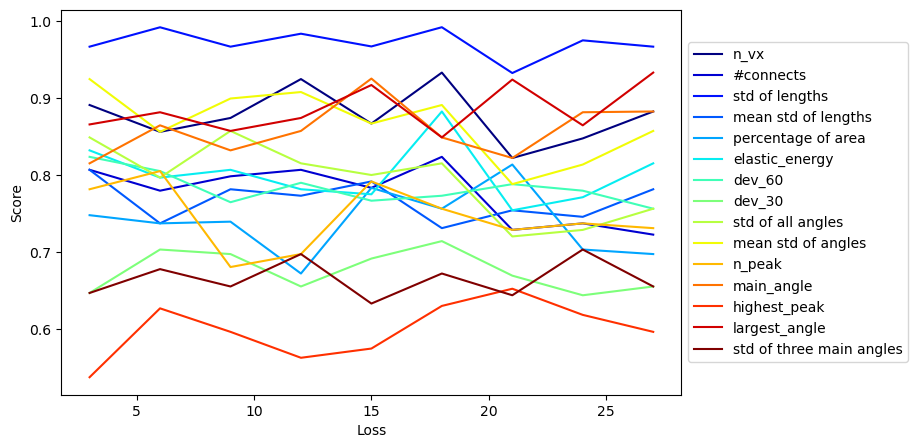

In [18]:
# acc=[]
# scs=[]
# for loss in range(1,10):
#     X, y, vxss, train_df = generateSimdata(loss=loss*3, noise=10, rand=2, n_samples=100)
#     idx=[ x for x in range(len(y)) if y[x]!=3]
#     for features in [[x] for x in range(len(X[0]))]:
#         t_score, accuracy, lbls = testAllClass(X[:,features][idx],y[idx], vxss=vxss,debug=0, methods=[6])
#         acc.append(accuracy)
#         scs.append(t_score)

# scs=np.array(scs)
# sscs = np.reshape(scs,[9,15])
fig = plt.figure(figsize=[10,5])
ax = plt.subplot(111)


for i, f in enumerate(columns):
    plt.plot([x*3 for x in range(1,10)],sscs[:,i], color=colors[i])
plt.xlabel("Loss")
plt.ylabel("Score")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(columns, loc='center left', bbox_to_anchor=(1, 0.5))

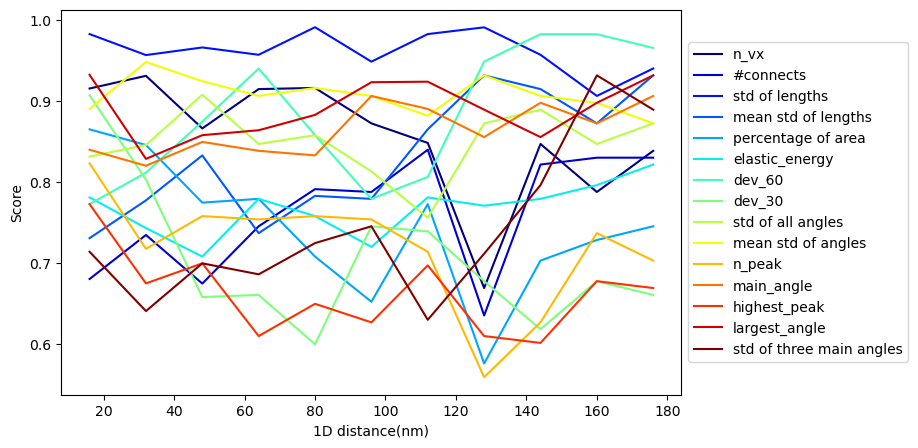

In [16]:
acc=[]
scs=[]
for x_1d in range(1,12):
    X, y, vxss, train_df = generateSimdata(loss=10, noise=5, rand=2, n_samples=100,x_1d=16*x_1d)
    idx=[ x for x in range(len(y)) if y[x]!=3]
    for features in [[x] for x in range(len(X[0]))]:
        t_score, accuracy, lbls = testAllClass(X[:,features][idx],y[idx], vxss=vxss,debug=0, methods=[6])
        acc.append(accuracy)
        scs.append(t_score)

scs=np.array(scs)
sscs = np.reshape(scs,[11,15])
fig = plt.figure(figsize=[10,5])
ax = plt.subplot(111)


for i, f in enumerate(columns):
    plt.plot([x*16 for x in range(1,12)],sscs[:,i], color=colors[i])
plt.xlabel("1D distance(nm)")
plt.ylabel("Score")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(columns, loc='center left', bbox_to_anchor=(1, 0.5))

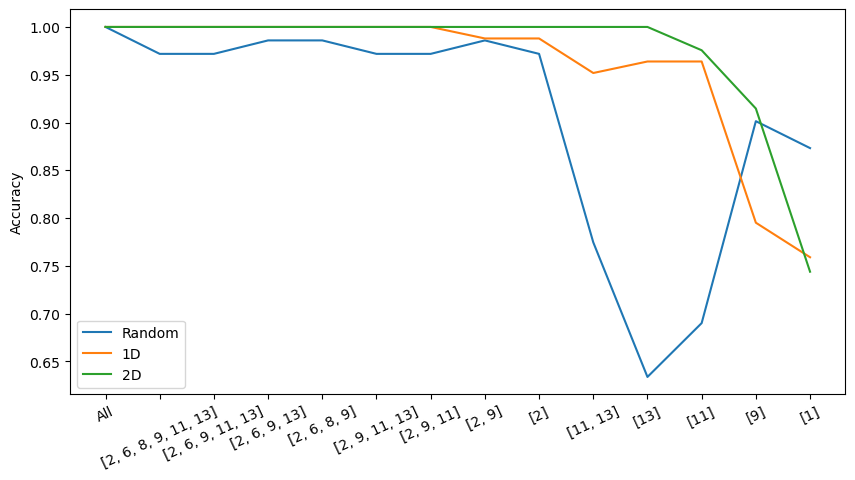

In [60]:
acc=[]
scs=[]
X, y, vxss, train_df = generateSimdata(loss=20, noise=10, rand=2, n_samples=200)
idx=[ x for x in range(len(y)) if y[x]!=3]

ffs = [[x for x in range(15)],[2,6,8,9,11,13],[2,6,9,11,13], [2,6,9,13],[2,6,8,9],[2,9,11,13],[2,9,11],[2,9],[2],[11,13],[13],[11],[9],[1]]
for features in ffs:
    t_score, accuracy, lbls = testAllClass(X[:,features][idx],y[idx], vxss=vxss,debug=0, methods=[6])
    acc.append(accuracy)
    scs.append(t_score)

plt.figure(figsize=[10,5])
plt.plot(np.array(acc)[:,0,:])
plt.xticks([x for x in range(len(ffs))],[str(ffs[x]) if x!=0 else "All" for x in range(len(ffs))],rotation=25)
plt.ylabel("Accuracy")
cats = ["Random","1D","2D","Random"]
plt.legend([cats[int(x)] for x in lbls])

In [120]:
idx=[ x for x in range(len(y)) if y[x]!=3]
acc=[]
scs=[]
for features in [[x for x in range(15) if x !=y] for y in range(15)]:
    t_score, accuracy, lbls = testAllClass(X[:,features][idx],y[idx], vxss=vxss,debug=0, methods=[6])
    acc.append(accuracy)
    scs.append(t_score)

In [ ]:
plt.figure(figsize=[10,5])
n = 15
colors = plt.cm.jet(np.linspace(0,1,n))
for i in range(15):
    plt.plot(np.array(tmp_scores)[i,0,:].T, color=colors[i])
plt.legend(columns)
plt.xlabel("Categories")
plt.ylabel("Accurracy")
plt.xticks(ticks=[0,1,2],labels=["Random","1D","2D"])

In [159]:
df = train_df[[cols[x] for x in [5,0,1,4,8,9,2,3,6, 13,14, 12,7,11,10,15]]]
corr_matrix = df.corr('spearman')
#plt.imshow(corr_matrix)
corr_matrix.abs().style.background_gradient(cmap='coolwarm')

NameError: name 'cols' is not defined

In [51]:
df = train_df[train_df['conds']==1].copy()
df = df[[cols[x] for x in [5,0,1,4,8,9,2,3,6, 13,14, 12,7,11,10,]]]
corr_matrix = df.corr('spearman')
#plt.imshow(corr_matrix)
corr_matrix.abs().style.background_gradient(cmap='coolwarm')

,elastic_energy,n_vx,#connects,percentage of area,std of all angles,mean std of angles,std of lengths,mean std of lengths,dev_60,largest_angle,std of three main angles,highest_peak,dev_30,main_angle,n_peak
elastic_energy,1.000000,0.117340,0.377107,0.467115,0.192391,0.252721,0.710543,0.687345,0.281656,0.065774,0.141752,0.277108,0.113759,0.143298,0.105226
n_vx,0.117340,1.000000,0.286202,0.410291,0.168121,0.136528,0.145464,0.044994,0.317960,0.033507,0.066817,0.125003,0.109044,0.136988,0.008874
#connects,0.377107,0.286202,1.000000,0.455031,0.704545,0.670600,0.231856,0.376273,0.210304,0.049286,0.194721,0.037606,0.114421,0.107427,0.210489
percentage of area,0.467115,0.410291,0.455031,1.000000,0.390853,0.389965,0.152171,0.223314,0.088564,0.094054,0.027265,0.119215,0.047669,0.054018,0.217243
std of all angles,0.192391,0.168121,0.704545,0.390853,1.000000,0.938506,0.116784,0.348215,0.128845,0.109194,0.040614,0.086541,0.023090,0.050476,0.209773
mean std of angles,0.252721,0.136528,0.670600,0.389965,0.938506,1.000000,0.194947,0.332169,0.200540,0.110398,0.082231,0.129085,0.003792,0.018730,0.295312
std of lengths,0.710543,0.145464,0.231856,0.152171,0.116784,0.194947,1.000000,0.810105,0.211377,0.062832,0.030447,0.315428,0.282472,0.037393,0.082144
mean std of lengths,0.687345,0.044994,0.376273,0.223314,0.348215,0.332169,0.810105,1.000000,0.312991,0.096002,0.012913,0.181938,0.137174,0.014251,0.069924
dev_60,0.281656,0.317960,0.210304,0.088564,0.128845,0.200540,0.211377,0.312991,1.000000,0.049354,0.031698,0.137822,0.062862,0.034338,0.133739
largest_angle,0.065774,0.033507,0.049286,0.094054,0.109194,0.110398,0.062832,0.096002,0.049354,1.000000,0.739935,0.087375,0.260404,0.829658,0.226977


In [52]:
df = train_df[train_df['conds']==0].copy()
df = df[[cols[x] for x in [5,0,1,4,8,9,2,3,6, 13,14, 12,7,11,10,]]]
corr_matrix = df.corr('spearman')
#plt.imshow(corr_matrix)
corr_matrix.abs().style.background_gradient(cmap='coolwarm')

,elastic_energy,n_vx,#connects,percentage of area,std of all angles,mean std of angles,std of lengths,mean std of lengths,dev_60,largest_angle,std of three main angles,highest_peak,dev_30,main_angle,n_peak
elastic_energy,1.000000,0.792321,0.866168,0.917427,0.840965,0.839678,0.143896,0.360816,0.167953,0.004815,0.035061,0.504378,0.116425,0.064742,0.104054
n_vx,0.792321,1.000000,0.887748,0.892476,0.825343,0.824266,0.222822,0.033740,0.172673,0.034600,0.022191,0.561874,0.048799,0.088932,0.083247
#connects,0.866168,0.887748,1.000000,0.954515,0.946673,0.950075,0.144949,0.109245,0.252017,0.041244,0.090835,0.536726,0.030874,0.074734,0.038976
percentage of area,0.917427,0.892476,0.954515,1.000000,0.936005,0.938169,0.123649,0.126592,0.311379,0.052020,0.069527,0.573185,0.053915,0.080141,0.116762
std of all angles,0.840965,0.825343,0.946673,0.936005,1.000000,0.995176,0.121917,0.155857,0.318466,0.058661,0.105046,0.521657,0.040804,0.058048,0.075023
mean std of angles,0.839678,0.824266,0.950075,0.938169,0.995176,1.000000,0.121793,0.145529,0.338330,0.067976,0.108701,0.525442,0.054818,0.046727,0.083057
std of lengths,0.143896,0.222822,0.144949,0.123649,0.121917,0.121793,1.000000,0.738973,0.428361,0.120021,0.075811,0.116957,0.107038,0.052221,0.072889
mean std of lengths,0.360816,0.033740,0.109245,0.126592,0.155857,0.145529,0.738973,1.000000,0.385356,0.129311,0.035883,0.026308,0.171503,0.053421,0.035417
dev_60,0.167953,0.172673,0.252017,0.311379,0.318466,0.338330,0.428361,0.385356,1.000000,0.115949,0.043088,0.194075,0.190068,0.002017,0.225739
largest_angle,0.004815,0.034600,0.041244,0.052020,0.058661,0.067976,0.120021,0.129311,0.115949,1.000000,0.827866,0.100692,0.111183,0.071400,0.069748


In [53]:
df = train_df[train_df['conds']==3].copy()
df = df[[cols[x] for x in [5,0,1,4,8,9,2,3,6, 13,14, 12,7,11,10,]]]
corr_matrix = df.corr('spearman')
#plt.imshow(corr_matrix)
corr_matrix.abs().style.background_gradient(cmap='coolwarm')

,elastic_energy,n_vx,#connects,percentage of area,std of all angles,mean std of angles,std of lengths,mean std of lengths,dev_60,largest_angle,std of three main angles,highest_peak,dev_30,main_angle,n_peak
elastic_energy,1.000000,0.755955,0.779057,0.812211,0.757377,0.757337,0.201649,0.179781,0.213602,0.003697,0.080432,0.368018,0.127893,0.191516,0.069920
n_vx,0.755955,1.000000,0.950599,0.953822,0.909690,0.915341,0.584117,0.299386,0.302636,0.010263,0.003707,0.530381,0.093316,0.060806,0.132094
#connects,0.779057,0.950599,1.000000,0.976359,0.970467,0.968160,0.555322,0.223005,0.360157,0.030523,0.049999,0.515970,0.153866,0.090702,0.093692
percentage of area,0.812211,0.953822,0.976359,1.000000,0.958776,0.962274,0.569535,0.236259,0.396552,0.000599,0.030666,0.530599,0.192641,0.103154,0.107064
std of all angles,0.757377,0.909690,0.970467,0.958776,1.000000,0.994280,0.550547,0.230289,0.434239,0.011195,0.045407,0.504668,0.198204,0.131049,0.065335
mean std of angles,0.757337,0.915341,0.968160,0.962274,0.994280,1.000000,0.565590,0.243636,0.450084,0.005157,0.026425,0.533308,0.207764,0.121190,0.087806
std of lengths,0.201649,0.584117,0.555322,0.569535,0.550547,0.565590,1.000000,0.685975,0.443312,0.038612,0.016109,0.251065,0.157558,0.061243,0.211719
mean std of lengths,0.179781,0.299386,0.223005,0.236259,0.230289,0.243636,0.685975,1.000000,0.372094,0.028087,0.095673,0.204134,0.048838,0.218786,0.233174
dev_60,0.213602,0.302636,0.360157,0.396552,0.434239,0.450084,0.443312,0.372094,1.000000,0.091603,0.039082,0.315340,0.361061,0.023620,0.064130
largest_angle,0.003697,0.010263,0.030523,0.000599,0.011195,0.005157,0.038612,0.028087,0.091603,1.000000,0.772786,0.127024,0.173786,0.043783,0.150159


In [72]:
df = train_df[train_df['conds']==2].copy()
df = df[[cols[x] for x in [5,0,1,4,8,9,2,3,6, 13,14, 12,7,11,10]]]
corr_matrix = df.corr('spearman')
#plt.imshow(corr_matrix)
corr_matrix.abs().style.background_gradient(cmap='coolwarm')

c:\Users\yxt5273\.conda\envs\jupyter\Lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\yxt5273\.conda\envs\jupyter\Lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,elastic_energy,n_vx,#connects,percentage of area,std of all angles,mean std of angles,std of lengths,mean std of lengths,dev_60,largest_angle,std of three main angles,highest_peak,dev_30,main_angle,n_peak,conds
elastic_energy,1.000000,0.195474,0.413261,0.349413,0.032091,0.052565,0.712367,0.715020,0.611053,0.235126,0.234383,0.323804,0.424722,0.051889,nan,nan
n_vx,0.195474,1.000000,0.366779,0.548113,0.261157,0.257699,0.134977,0.066224,0.078782,0.055702,0.047616,0.085564,0.030825,0.102514,nan,nan
#connects,0.413261,0.366779,1.000000,0.726112,0.745334,0.718574,0.005706,0.072568,0.056944,0.001611,0.028807,0.052007,0.084690,0.001675,nan,nan
percentage of area,0.349413,0.548113,0.726112,1.000000,0.648541,0.640032,0.177134,0.142390,0.187887,0.018954,0.046329,0.133701,0.084273,0.047016,nan,nan
std of all angles,0.032091,0.261157,0.745334,0.648541,1.000000,0.953255,0.317156,0.288881,0.399868,0.095016,0.077714,0.155668,0.263330,0.130981,nan,nan
mean std of angles,0.052565,0.257699,0.718574,0.640032,0.953255,1.000000,0.413093,0.398992,0.501950,0.143273,0.132817,0.202004,0.283864,0.141171,nan,nan
std of lengths,0.712367,0.134977,0.005706,0.177134,0.317156,0.413093,1.000000,0.919232,0.787771,0.263101,0.223552,0.412265,0.432967,0.042925,nan,nan
mean std of lengths,0.715020,0.066224,0.072568,0.142390,0.288881,0.398992,0.919232,1.000000,0.792475,0.323862,0.267800,0.394599,0.441968,0.021232,nan,nan
dev_60,0.611053,0.078782,0.056944,0.187887,0.399868,0.501950,0.787771,0.792475,1.000000,0.336158,0.319023,0.436448,0.345347,0.135262,nan,nan
largest_angle,0.235126,0.055702,0.001611,0.018954,0.095016,0.143273,0.263101,0.323862,0.336158,1.000000,0.910986,0.289418,0.178013,0.233859,nan,nan


In [66]:
def statsForVXS(vxs, thre=[150, 220], mode=1, std=187, relaxed_length=100, bandwidth=12, plot=0):
    # use density and connectivity as rules for simulating data
    # connectivity
    # uniformity: distance to the mean length
    # sparsity: percentage of area / Nextra
    # energy: 1/2*k*deltax^2
    n_vx = len(vxs)
    links = generateLinks(vxs, thre=thre, plot=plot)
    connects = np.mean(np.sum(links, 0))
    angles = getAngle(vxs, links)

    if mode == 0:
        return [n_vx, connects]

    tri_list = getTrianglesFromList(convertMatrix2List(links))
    # t_vxs = getTrianglesCentroid(tri_list, vxs)
    dist = distance_matrix(vxs, vxs)
    linked_dist = links * dist
    lengths = [[x for x in y if x != 0] for y in linked_dist]
    mean_length_std = np.mean([np.std(x) for x in lengths if len(x) > 1])
    lengths = [x for x in linked_dist.flatten() if x != 0]
    length_std = np.std(lengths)
    x0, y0 = np.min(vxs, 0)
    x1, y1 = np.max(vxs, 0)
    p_area = AreaCoveredByTriangles(tri_list, vxs) / (y1 - y0) / (x1 - x0)
    elastic_energy = np.sum([1 / 2 * (x - relaxed_length) ** 2 for x in lengths])
    dev_60 = calAngleDev(angles, 60)
    dev_30 = calAngleDev(angles, 30)
    mean_angle_std = np.mean([np.std(x) for x in angles if len(x) > 1])
    all_angles = []
    for x in angles:
        all_angles.extend(x)
    angle_std = np.std(all_angles)
    # v_c = Voronoi_cv(vxs)
    # v_e = Voronoi_edges(vxs)
    # tris = len(t_vxs)

    angles = getTop3Angle(vxs, links)
    angles = np.array(angles).reshape(-1, 1)
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(angles)
    s = np.linspace(-180, 180, 361)
    probs = kde.score_samples(s.reshape(-1, 1))

    l_min, l_max = argrelextrema(probs, np.less)[0], argrelextrema(probs, np.greater)[0]
    # print(l_max)
    peaks_idx = [x for x in l_max if x < l_max[1] + 180][1:]
    # print(peaks_idx)
    n_peak = len(peaks_idx)
    peaks_prob = [probs[x] for x in peaks_idx]
    highest_peak = max(peaks_prob)
    peaks_angle = [peaks_idx[x] for x in np.argsort(peaks_prob)[-3:][::-1]]
    if n_peak == 1:
        main_angle = 180
        largest_angle = 180
        std_angles = 0
    else:
        main_angle = (
            np.abs(peaks_angle[1] - peaks_angle[0])
            if np.abs(peaks_angle[1] - peaks_angle[0]) <= 90
            else 180 - np.abs(peaks_angle[1] - peaks_angle[0])
        )
        angles = np.sort(peaks_angle)
        angles = np.concatenate(
            (angles[1:] - angles[:-1], [180 - np.sum(angles[1:] - angles[:-1])])
        )
        largest_angle = np.max(angles)
        std_angles = np.std(angles)
    return [
        n_vx,
        connects,
        length_std,
        mean_length_std,
        p_area,
        elastic_energy,
        dev_60,
        dev_30,
        angle_std,
        mean_angle_std,
        n_peak,
        main_angle,
        highest_peak,
        largest_angle,
        std_angles,
    ]

[54,
 4.925925925925926,
 30.918620911861943,
 25.720971913685972,
 0.8552227342549924,
 614640.734825993,
 158.72770650300518,
 971.5620139634738,
 43.011319257343224,
 34.67223058139961,
 3,
 64,
 -5.466583562404011,
 64,
 2.943920288775949]

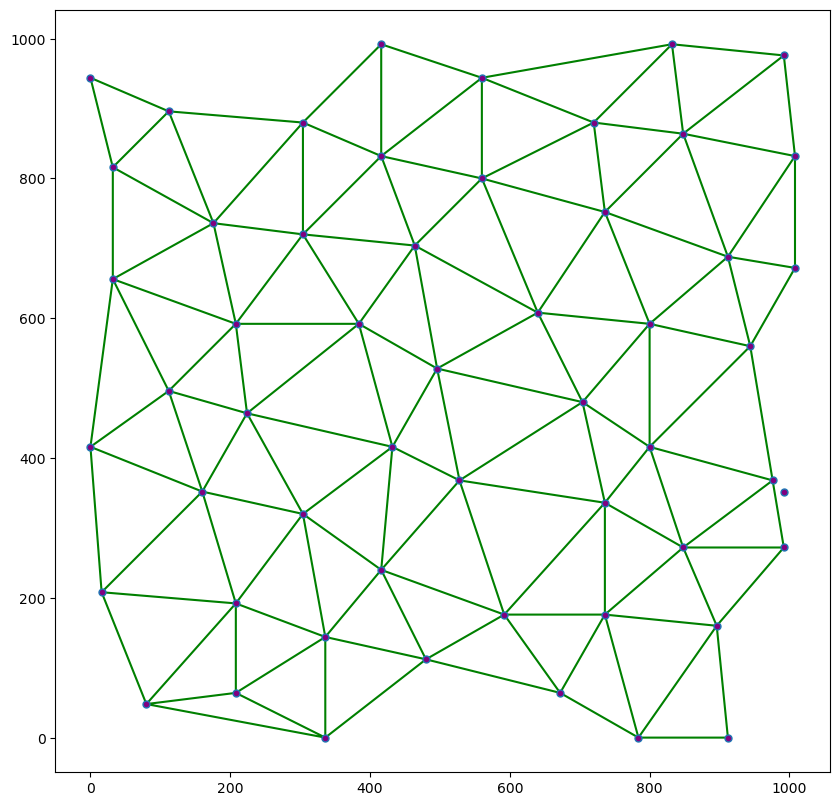

In [68]:
p_size=16
loss=20
noise=5
rand=2
t_r=0.15
thre=[50,280]
vxs_2D = sim2D(size=int(2*64*16/p_size), space=int(187/p_size/2))
vxs_2D = jitter(vxs_2D,loss=np.random.randint(loss),noise=noise)
sim_2D = genPic(np.zeros([128,128]), vxs_2D, 5, theta=np.random.rand()*180, rand=rand, randz=3)
mat = sim_2D[32:32+64,32:32+64]
vxs = readVXSfromMat(sim_2D[32:32+64,32:32+64], min_sigma=0.5,max_sigma=1,num_sigma=20, threshold_rel=t_r,plot=0)[0]
statsForVXS(vxs*16,thre=thre,plot=1)